# 评估模型

## 导入包

In [83]:
import time
import cv2
import os
import numpy as np
from PIL import Image
from unet import Unet
import matplotlib
import matplotlib.pyplot as plt
from torchsummary import summary
from tqdm import tqdm
import scipy.signal
%matplotlib inline

## 创建模型

模式=预测

In [3]:
#-------------------------------------------------------------------------#
#   如果想要修改对应种类的颜色，到generate函数里修改colors即可
#-------------------------------------------------------------------------#
unet = Unet()
#-------------------------------------------------------------------------#
#   mode用于指定测试的模式：
#-------------------------------------------------------------------------#
mode = "predict"
summary(unet.net,(3,512,512))


logs/Epoch44-Total_Loss0.0483-Val_Loss0.0874.pth model loaded.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,792
              ReLU-2         [-1, 64, 512, 512]               0
            Conv2d-3         [-1, 64, 512, 512]          36,928
              ReLU-4         [-1, 64, 512, 512]               0
         MaxPool2d-5         [-1, 64, 256, 256]               0
            Conv2d-6        [-1, 128, 256, 256]          73,856
              ReLU-7        [-1, 128, 256, 256]               0
            Conv2d-8        [-1, 128, 256, 256]         147,584
              ReLU-9        [-1, 128, 256, 256]               0
        MaxPool2d-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 256, 128, 128]         295,168
             ReLU-12        [-1, 256, 128, 128]               0
           Conv2d-13        [-1, 256, 12

展示训练保存的acc-loss图

In [74]:
losses_path = './logs/loss_2021_09_17_11_22_21/epoch_loss_2021_09_17_11_22_21.txt'
val_losses_path = './logs/loss_2021_09_17_11_22_21/epoch_val_loss_2021_09_17_11_22_21.txt'

In [89]:
loss_list = []
val_loss_list = []

loss_lines = open(losses_path,'r').read().splitlines()
val_loss_lines = open(val_losses_path,'r').read().splitlines()
for i in range(len(loss_lines)):
    loss_list.append(float(loss_lines[i]))
    val_loss_list.append(float(val_loss_lines[i]))


Text(0.5, 1.0, 'loss')

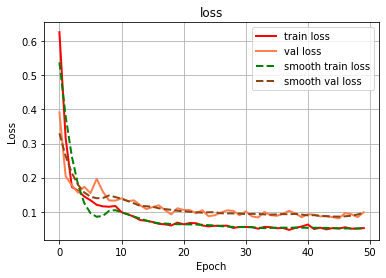

In [88]:
iters = range(len(loss_list))

plt.figure()
plt.plot(iters, loss_list, 'red', linewidth = 2, label='train loss')
plt.plot(iters, val_loss_list, 'coral', linewidth = 2, label='val loss')

try:
    if len(loss_list) < 25:
        num = 5
    else:
        num = 15
    
    plt.plot(iters, scipy.signal.savgol_filter(loss_list, num, 3), 'green', linestyle = '--', linewidth = 2, label='smooth train loss')
    plt.plot(iters, scipy.signal.savgol_filter(val_loss_list, num, 3), '#8B4513', linestyle = '--', linewidth = 2, label='smooth val loss')
except:
    pass

plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.title('loss')
# plt.savefig(os.path.join(save_path, "epoch_loss_" + str(time_str) + ".png"))

## 预测图像

In [96]:
img_path = 'VOCdevkit/VOC2007/JPEGImages/141.jpg'
img = Image.open(img_path)

r_img,gray_img,seg_img = unet.detect_image(img)
r_img = np.array(r_img)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


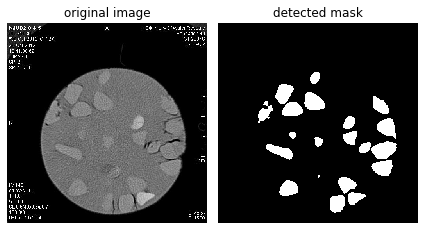

In [97]:

plt.subplot(1,2,1)
plt.imshow(img)
plt.title("original image")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(seg_img)
plt.title("detected mask")
plt.axis("off")
plt.tight_layout()
plt.savefig('display_result.png')

## 评估模型miou

In [32]:
from get_miou_prediction import miou_Unet

miou_unet = miou_Unet()

logs/Epoch44-Total_Loss0.0483-Val_Loss0.0874.pth model loaded.


In [26]:
image_ids = open("VOCdevkit/VOC2007/ImageSets/Segmentation/val.txt",'r').read().splitlines()
print("validation images ======>\n",images_ids)

validation images ======>
 ['144', '71', '111', '2', '125', '13', '110', '66', '21', '75', '145', '39', '15', '112', '141']


### 依次得到val的miou_Unet预测结果

In [33]:
if not os.path.exists("./miou_pr_dir"):
    os.makedirs("./miou_pr_dir")
    
for image_id in tqdm(image_ids):
    image_path = "VOCdevkit/VOC2007/JPEGImages/"+image_id+".jpg"
    image = Image.open(image_path)
    image = miou_unet.detect_image(image)
    image.save("miou_pr_dir/" + image_id + ".png")

100%|██████████| 15/15 [01:30<00:00,  6.03s/it]


In [34]:
from miou import compute_mIoU
gt_dir = "VOCdevkit/VOC2007/SegmentationClass"
pred_dir = "miou_pr_dir"
png_name_list = open("VOCdevkit/VOC2007/ImageSets/Segmentation/val.txt",'r').read().splitlines() 
#------------------------------#
#   分类个数+1
#   2+1
#------------------------------#
num_classes = 2
#--------------------------------------------#
#   区分的种类，和json_to_dataset里面的一样
#--------------------------------------------#
name_classes = ["background", "rock"]

In [35]:
compute_mIoU(gt_dir, pred_dir, png_name_list, num_classes, name_classes)  # 执行计算mIoU的函数

Num classes 2
10 / 15: mIou-92.14; mPA-95.85
===>background:	mIou-98.59; mPA-99.28
===>rock:	mIou-85.42; mPA-92.21
===> mIoU: 92.01; mPA: 95.75


array([0.98591996, 0.85419063])